In [1]:
import random
import sys
import os
import copy
import re

In [2]:
%matplotlib inline
import plotnine as p9
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from collections import defaultdict
from datasets import load_dataset


In [3]:
import utils
import metrics


In [4]:
WEBTEXT_DIR = '.'
MAUVE_SCORES_DIR = 'data/mauve_scores_full'
TENSOR_STORAGE_DIR = '/local/home/meistecl/tensors'
NUM_HYPS = 1000

In [5]:
base_factors = ['adapter', 'param', 'model', 'dataset']
variation_factors = base_factors + ['comparison']
corr_factors = ['comparison', 'model']


## Data

In [6]:
webtext_dir_name = os.path.join(WEBTEXT_DIR, 'data')
webtext_human = utils.clean_text(utils.load_gpt2_dataset(os.path.join(webtext_dir_name,'webtext.test.jsonl'), num_examples=NUM_HYPS)) # human

In [7]:
wikitext_test = utils.clean_text(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")['text'])

Found cached dataset wikitext (/home/meistecl/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


In [8]:
def prettify_adapter_names(x):
    x = x.title()
    if 'Top' in x:
        x = x[:-1] + x[-1].upper()
    return x

def prettify_model_names(x):
    mapping = {'gpt-neo': 'GPT-Neo', 'gpt2':'GPT-2', 'gpt2-large':'GPT-2 Large'}
    return mapping.get(x)


mauve_scores = pd.DataFrame()
for d in os.listdir(MAUVE_SCORES_DIR):
    if not os.path.isdir(os.path.join(MAUVE_SCORES_DIR, d)):
        continue
    params = d.split('_')
    ms = utils.get_mauve_scores_from_files(os.path.join(MAUVE_SCORES_DIR, d))
    ms['laplace'] = int(d[-1])
    ms['mauve_eval'] = params[-2]
    ms['model'] = params[-4]
    ms['dataset'] = params[-3]
    ms.loc[ms['adapter'] == 'ancestral', 'param'] = np.nan
    columns = ['mauve_scores', 'js_scores'] 
    if 'laplace1' in d:
        columns +=  ['forward_scores', 'backward_scores']
    mauve_scores = pd.concat([mauve_scores, ms.explode(columns)])


mauve_scores = mauve_scores.apply(pd.to_numeric, errors='ignore').reset_index(drop=True)
mauve_scores['adapter'] = mauve_scores['adapter'].apply(prettify_adapter_names)
mauve_scores['model'] = mauve_scores['model'].apply(prettify_model_names)


## Models

In [9]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AutoTokenizer, AutoModelForCausalLM, AutoConfig
from accelerate import init_empty_weights

device = "cuda:6"
model_id = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)
model = GPT2LMHeadModel.from_pretrained(model_id, pad_token_id=tokenizer.eos_token_id).to(device)

device2 = "cuda:7"
model2_id = "gpt2-xl"
model2 = GPT2LMHeadModel.from_pretrained(model2_id).to(device2)
tokenizer2 = GPT2TokenizerFast.from_pretrained(model2_id)

device3 = "cpu"
model3_id = "EleutherAI/gpt-j-6B"
config = AutoConfig.from_pretrained(model3_id)
with init_empty_weights():
    model3 = AutoModelForCausalLM.from_config(config)
# model3 = AutoModelForCausalLM.from_pretrained(model3_id).to(device3)
tokenizer3 = AutoTokenizer.from_pretrained(model3_id)


In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, AutoTokenizer, AutoModelForCausalLM
device = "cuda"
model_id = "gpt2"
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)
model = GPT2LMHeadModel.from_pretrained(model_id, pad_token_id=tokenizer.eos_token_id).to(device)

device2 = "cuda:1"
model2 = GPT2LMHeadModel.from_pretrained("gpt2-large").to(device2)
tokenizer2 = GPT2TokenizerFast.from_pretrained("gpt2-large")

device3 = "cpu"
model3 = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B").to(device3)
tokenizer3 = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")


In [ ]:
device = "cuda:2"
model_id = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, pad_token_id=tokenizer.eos_token_id).to(device)

device2 = "cuda:3"
model2_id = "EleutherAI/gpt-neo-1.3B"
model2 = AutoModelForCausalLM.from_pretrained(model2_id).to(device2)
tokenizer2 = AutoTokenizer.from_pretrained(model2_id)


## Experiments

In [10]:
# Sampling adapter methods
from transformers import TypicalLogitsWarper, TopKLogitsWarper, TopPLogitsWarper, TemperatureLogitsWarper, LogitsProcessorList
from utils import EtaWarper

ADAPTERS = [(EtaWarper, [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]),
          (TopKLogitsWarper, [1, 5, 10, 30, 50, 100, 500, 1000, 10000]),
          (TopPLogitsWarper, [0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]),
          (TypicalLogitsWarper, [0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999 ]),
           (TemperatureLogitsWarper, [0.3, 0.5, 0.7, 0.9, 0.95, 1.05, 1.2])]


In [11]:
def compute_metrics_wrapper(log_probs, reference_log_probs, reference=None):
    js, (forward_js, backward_js) = metrics.jensen_shannon(reference_log_probs, log_probs)
    m = metrics.Metrics(tvd=metrics.tvd(torch.exp(log_probs), torch.exp(reference_log_probs)).cpu().numpy(),
                   forward_kl=metrics.forward_kl(reference_log_probs, log_probs).cpu().numpy(),
                   backward_kl=metrics.backward_kl(reference_log_probs, log_probs).cpu().numpy(),
                  js=js.cpu().numpy(), forward_js=forward_js.cpu().numpy(), backward_js=backward_js.cpu().numpy(),
                  token_counts=len(log_probs),
                  entropy=metrics.entropy(log_probs).cpu().numpy(),
                  reference_entropy=metrics.entropy(reference_log_probs).cpu().numpy(),
                  cross_entropy=metrics.cross_entropy(reference_log_probs, log_probs).cpu().numpy(),
                  eps_forward_kl=metrics.eps_forward_kl(reference_log_probs, log_probs).cpu().numpy(),
                  eps_backward_kl=metrics.eps_backward_kl(reference_log_probs, log_probs).cpu().numpy()
                     )
    if reference is not None:
        m = m._replace(inf_counts=metrics.inf_counts(log_probs, reference).item())            
        m = m._replace(perplexity=metrics.perplexity(log_probs, reference).item())
        m = m._replace(eps_perplexity=metrics.epsilon_perplexity(log_probs, reference).item())
    return m

In [12]:
num_examples = 10
cur_text = webtext_human

all_results = {}
all_results['reference'] = defaultdict(lambda: defaultdict(list))
all_results['reference_model'] = defaultdict(lambda: defaultdict(list))
all_results['reference_model2'] = defaultdict(lambda: defaultdict(list))
for t in tqdm(cur_text[:num_examples]):
    logits, tensor_input = utils.get_model_outputs2(t, model, tokenizer, tensor_dir=TENSOR_STORAGE_DIR, device=model.device)
    labels = tensor_input[..., 1:].contiguous()
    
    logits_model2, _ = utils.get_model_outputs2(t, model2, tokenizer2, tensor_dir=TENSOR_STORAGE_DIR)
    logits_model2 = logits_model2.to(logits.device)
    
    logits_model3, _ = utils.get_model_outputs2(t, model3, tokenizer3, tensor_dir=TENSOR_STORAGE_DIR)
    logits_model3 = logits_model3[:, :logits.shape[-1]].to(logits.device)
    
    p = torch.nn.functional.one_hot(labels.view(-1), num_classes=logits.shape[1])
    log_p = torch.log(p.float())
    for warper, hyperparam in ADAPTERS:
        all_results['reference'][warper.__name__]['-'].append(compute_metrics_wrapper(logits, log_p, labels))
        all_results['reference_model'][warper.__name__]['-'].append(compute_metrics_wrapper(logits, logits_model2))
        all_results['reference_model2'][warper.__name__]['-'].append(compute_metrics_wrapper(logits, logits_model3))
        for h in hyperparam:
            processor = LogitsProcessorList()
            processor.append(warper(h))
            # Labels are input to processor but arent actually used. Could even put arbitrary list of token ids...
            shift_logits = processor(
              labels.squeeze(0), logits.squeeze(0)).unsqueeze(0)
            shift_logits = torch.nn.functional.log_softmax(shift_logits.view(-1, shift_logits.size(-1)), dim=1)
            all_results['reference'][warper.__name__][h].append(compute_metrics_wrapper(shift_logits, log_p, labels))        
            all_results['reference_model'][warper.__name__][h].append(compute_metrics_wrapper(shift_logits, logits_model2))        
            all_results['reference_model2'][warper.__name__][h].append(compute_metrics_wrapper(shift_logits, logits_model3))        


100%|██████████| 10/10 [00:51<00:00,  5.11s/it]


In [16]:
all_results_df = utils.dict_to_df(all_results)

all_results_df['sequence_coverage'] = (all_results_df['inf_counts'] == 0.).astype(int)
all_results_df['token_coverage'] = (all_results_df['token_counts'] - all_results_df['inf_counts'])/all_results_df['token_counts']
all_results_df['eps_backward_cross_ent'] = all_results_df['entropy'] + all_results_df['eps_backward_kl']
all_results_df['backward_cross_ent'] = all_results_df['entropy'] + all_results_df['backward_kl']
all_results_df['eps_forward_cross_ent'] = all_results_df['reference_entropy'] + all_results_df['eps_forward_kl']
all_results_df['model'] = model_id
all_results_df['dataset'] = "webtext"

In [17]:
from scipy.stats import sem
def nansem(x):
    try: 
        return sem(x.explode())
    except:
        return np.nan
grouped = all_results_df.groupby(variation_factors, dropna=False).aggregate(lambda x: np.mean(x.explode()))
grouped_sem = all_results_df.groupby(variation_factors, dropna=False).aggregate(nansem)
grouped = grouped.join(grouped_sem, rsuffix='_se')
grouped = grouped.reset_index()
grouped['adapter'] = grouped['adapter'].apply(lambda x: x.replace('Logits', '').replace('Warper', ''))
grouped['param'] =  pd.to_numeric(grouped['param'], errors='coerce')
grouped['model'] = grouped['model'].apply(prettify_model_names)
grouped.loc[grouped['adapter'] == 'TopK','param'] = grouped.loc[grouped['adapter'] == 'TopK','param'].astype('Int64')


/home/meistecl/Documents/repositories/jupyter/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in scalar subtract
/home/meistecl/Documents/repositories/jupyter/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: invalid value encountered in subtract


### Correlations

In [27]:
from scipy.stats import spearmanr
merged = grouped.merge(mauve_scores.loc[mauve_scores['laplace'] == 1], on=base_factors, suffixes=['', '_mauve'])
corrs = merged.groupby(corr_factors).corr(method='spearman', numeric_only=True)[['mauve_scores', 'forward_scores', 'backward_scores']].reset_index(names=corr_factors+['att'])
corrs_std = merged.groupby(corr_factors).corr(method=lambda x, y: spearmanr(x, y)[1], numeric_only=True)[['mauve_scores', 'forward_scores', 'backward_scores']].reset_index(names=corr_factors+['att'])

/home/meistecl/Documents/repositories/jupyter/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/home/meistecl/Documents/repositories/jupyter/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
/home/meistecl/Documents/repositories/jupyter/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


In [28]:
atts = ['backward_cross_ent','tvd', 'backward_kl', 'eps_forward_kl', 'eps_backward_kl','js', 'sequence_coverage', 'entropy']
corrs_std.loc[corrs['att'].isin(atts) & corrs['comparison'].isin(['reference', 'gptj'])].sort_values(by=['mauve_scores'])#.to_csv('corr_pvals.csv')
corrs.loc[corrs['att'].isin(atts) & corrs['comparison'].isin(['reference', 'gptj'])].sort_values(by=['mauve_scores'])#.to_csv('corrs.csv')

,comparison,model,att,mauve_scores,forward_scores,backward_scores
4,reference,GPT-2,eps_forward_kl,-0.310455,0.194325,0.460303
5,reference,GPT-2,eps_backward_kl,-0.157111,0.075859,0.318721
16,reference,GPT-2,sequence_coverage,-0.026207,0.119612,-0.239899
6,reference,GPT-2,js,0.063020,0.009321,-0.402480
1,reference,GPT-2,tvd,0.102533,-0.013146,-0.423482
10,reference,GPT-2,entropy,0.298203,-0.185661,-0.497919
3,reference,GPT-2,backward_kl,NaN,NaN,NaN
19,reference,GPT-2,backward_cross_ent,NaN,NaN,NaN


## Plots

In [29]:
label_mapping = {'reference': 'Empirical',
                 'gpt2': 'GPT2-XL',
                 'gpt_neo': 'GPT-Neo (1.5B)',
                 'gptj': 'GPT-J',
                 }
metric_mapping = {'tvd': 'TVD',
                 'js': 'Jensen-Shannon',
                  'entropy': 'Entropy',
                  'backward_kl': "Reverse KL",
                  'eps_perplexity': r'$\epsilon$'+"-Perplexity",
                  'eps_forward_kl': "Forward KL\n",
                  'backward_cross_ent': "Reverse Cross-Entropy",
                  'eps_forward_cross_ent': "Forward Cross-Entropy",
                  'eps_backward_kl': r'$\epsilon$'+"-Reverse KL\n",
                  'token_coverage': "Token Coverage (%)"
                 }
def labeller(x):
    return label_mapping.get(x, x)

def equal_breaks(n, r=2, min_size=0.5):
    def create_breaks(x):
        min_ = min(x)
        max_ = max(x)
        cur_delt = max_ - min_
        if cur_delt < min_size:
            max_ += (min_size - cur_delt)/2
            min_ -= (min_size - cur_delt)/2
        delta = np.round((max_ - min_)/n, r)
        d = list(np.arange(np.floor(min_ * 10**r)/10**r, max_, delta))
        return d
    return create_breaks


In [30]:
with pd.option_context('mode.use_inf_as_na', True):
    grouped.loc[pd.isna(grouped['backward_cross_ent']),'backward_cross_ent'] = grouped.loc[pd.isna(grouped['backward_cross_ent']),'eps_backward_cross_ent'] 
    grouped.loc[pd.isna(grouped['backward_kl']),'backward_kl'] = grouped.loc[pd.isna(grouped['backward_kl']),'eps_backward_kl'] 

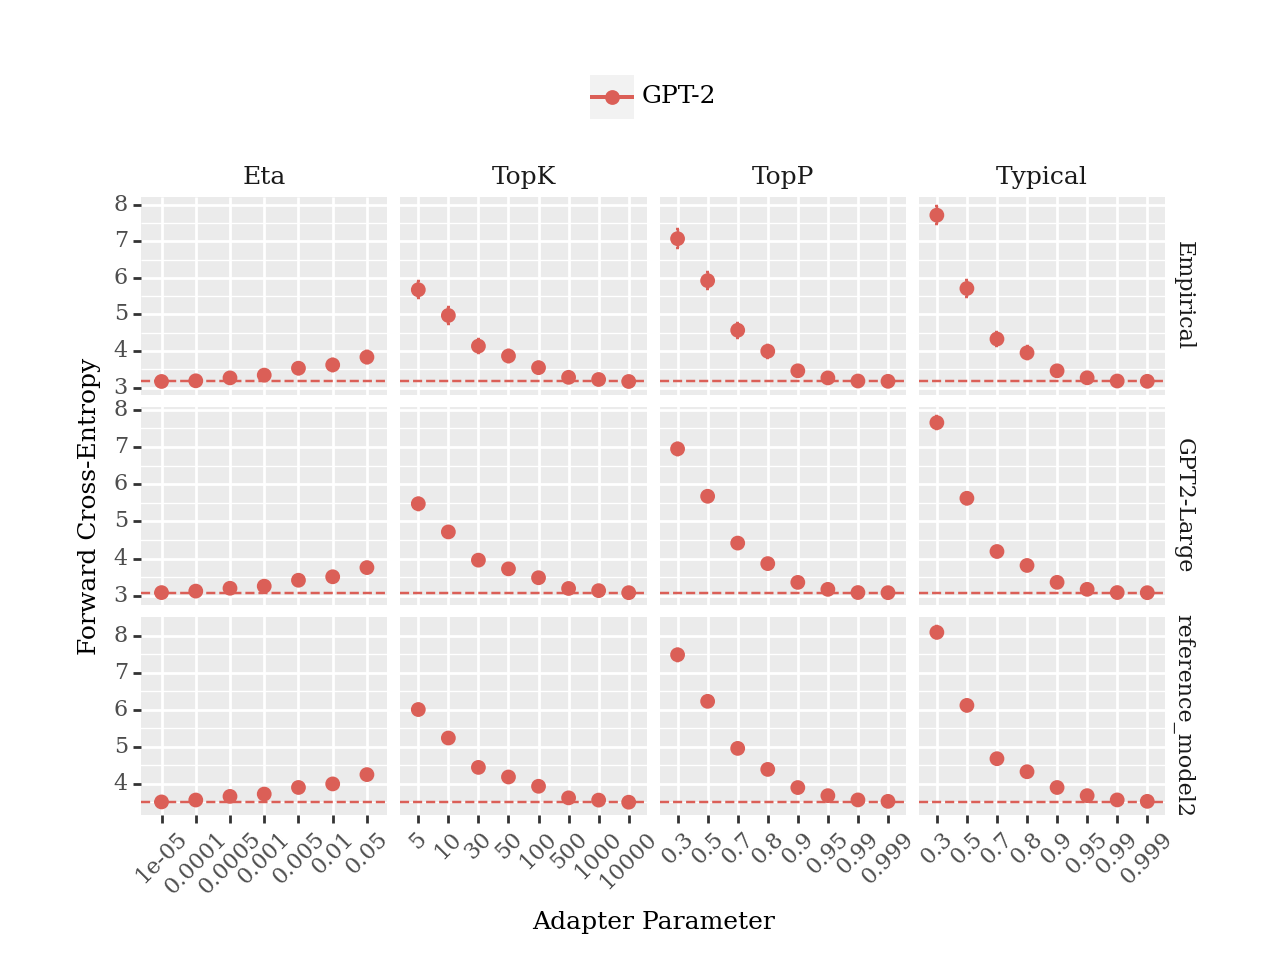

In [34]:
metric = 'eps_forward_cross_ent'
dataset = 'webtext'
filtered = grouped.loc[(grouped['dataset'] == dataset)]#.dropna(subset=[metric])
no_adapter = filtered.loc[pd.isna(filtered['param'])]
adapters = filtered.drop(no_adapter.index, errors='ignore', axis=0).apply(pd.to_numeric, errors='ignore')
adapters = adapters.loc[~adapters['param'].isin([0.1, 1.])]
fig = (p9.ggplot(data=adapters,#.loc[adapters[metric]<10],
               mapping=p9.aes(x='factor(param)', y=metric, color='model'))
         + p9.theme(text=p9.element_text(size=9, family='serif'), 
               axis_text_x=p9.element_text(size=8, angle=45),
               axis_text_y=p9.element_text(size=8),
               strip_text_y=p9.element_text(size=8),
               aspect_ratio=0.8,
               legend_position='top',
                strip_background = p9.element_rect(fill="white"))
        + p9.geom_point(size=2)
        + p9.geom_errorbar(mapping=p9.aes( ymin=metric + '-1.96*' + metric + '_se', ymax=metric + '+1.96*' + metric + '_se'), width=0.1)
        + p9.facet_grid('comparison~adapter', scales='free', labeller=labeller)
        + p9.geom_hline(mapping=p9.aes(yintercept=metric, color='model'), data=no_adapter, linetype='dashed')
        + p9.labs(x="Adapter Parameter", color="", y=metric_mapping.get(metric, metric))
        + p9.scale_x_discrete(labels=lambda x: [str(int(y)) if float(y) >= 5 else str(y) for y in x])

).draw(show=False)
#fig.savefig(metric+ '_' + dataset +'.png', dpi=300, bbox_inches = "tight")
fig

In [60]:
metric='mauve_scores'
laplace = 1
mauve_scores_subet = mauve_scores.loc[mauve_scores['laplace']== laplace][base_factors + [metric, 'mauve']].drop_duplicates()
gptj = grouped.loc[grouped['comparison'] == 'gptj']
reference = grouped.loc[grouped['comparison'] == 'reference']

df = gptj
mauve_adapters = df.loc[~pd.isna(df['param'])].merge(mauve_scores_subet, on=base_factors, how='left')
mauve_ancestral = df.loc[pd.isna(df['param'])].merge(mauve_scores_subet[mauve_scores_subet.columns.drop('adapter')], on=[n for n in base_factors if n != 'adapter'], how='left')
mauve_df = pd.concat([mauve_ancestral, mauve_adapters])


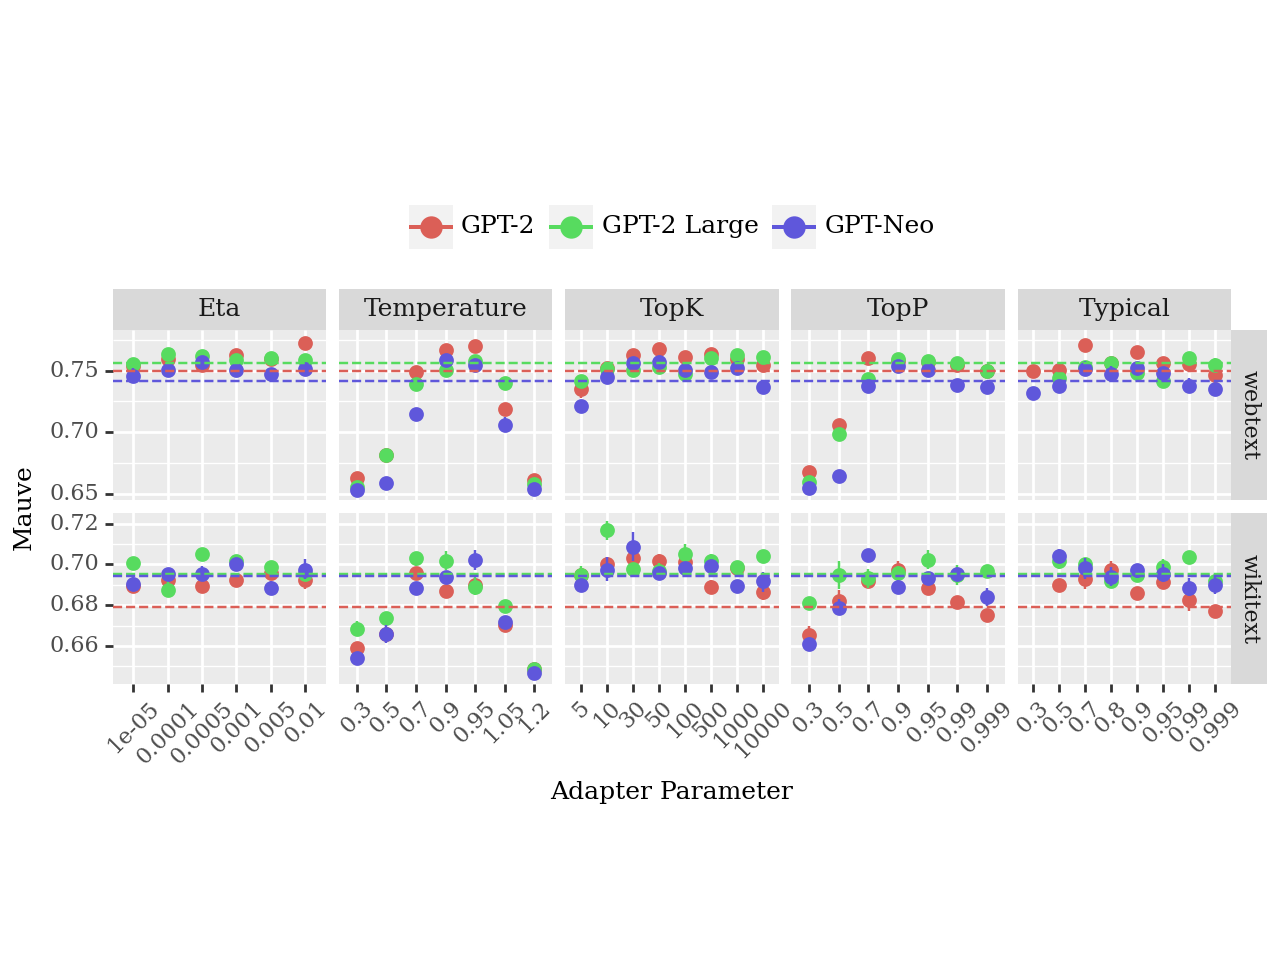

In [254]:
## Mauve Scores figure
filtered = mauve_df.apply(pd.to_numeric, errors='ignore').dropna(subset=[metric]).reset_index(drop=True) #.drop_duplicates(subset=['model','adapter', 'param', 'dataset'])
subset = filtered#.loc[filtered['dataset'] == 'webtext']
no_adapter = subset.loc[pd.isna(subset['param'])]
adapters = subset.drop(no_adapter.index, errors='ignore', axis=0)
adapters = adapters.loc[((adapters['param'] != 1.) & (adapters['param'] != 0.1))]
fig = (p9.ggplot(data=adapters.sort_values(by=['param']),
               mapping=p9.aes(x='factor(param)', y=metric, color='model'))
         + p9.theme(text=p9.element_text(size=9, family='serif'), 
               axis_text_x=p9.element_text(size=8, angle=45),
               axis_text_y=p9.element_text(size=8),
               strip_text_y=p9.element_text(size=8),
               aspect_ratio=0.8,
               legend_position='top')
        + p9.stat_summary(fun_data = 'mean_cl_boot', size=0.5, fun_args={'confidence_interval':0.95})
        + p9.facet_grid('dataset~adapter', scales='free', labeller=labeller)
        + p9.geom_hline(mapping=p9.aes(yintercept='mauve', color='model'), data=no_adapter, linetype='dashed')
        + p9.labs(x="Adapter Parameter", color="", y=metric_mapping.get(metric, metric.split('_')[0].title()))
        + p9.scale_x_discrete(labels=lambda x: [str(int(y)) if float(y) >= 5 else str(y) for y in x])

).draw(show=False)
fig.savefig(metric+'_wide.png', dpi=300, bbox_inches = "tight")
fig